## Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from collections import deque
import pickle

# Training SVM 

In [2]:
#Converts Image Colour for Formatting
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2Lab':
        return cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [3]:
# HOG features of image
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualize=vis, feature_vector=feature_vec)
        return features

In [4]:
# Spatial features of image
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [5]:
# Hist features of image
def color_hist(img, nbins=32, hist_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=hist_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=hist_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=hist_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image *= 255.0
        #image = image.astype(np.uint8)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'RGB2HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'RGB2LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'RGB2HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'RGB2YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'RGB2YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'RGB2Lab':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, hist_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Importing Dataset

In [7]:
vehicles = glob.glob('F:/data/vehicles/*.png')
nonvehicles = glob.glob('F:/data/non-vehicles/*.png')

print("Number of Vehicles in Dataset: ", len(vehicles))
print("Number of Non-Vehicles in Dataset:",len(nonvehicles))

Number of Vehicles in Dataset:  8792
Number of Non-Vehicles in Dataset: 8968


SVM Parameters

In [8]:
color_space = 'RGB2YCrCb' # Can be RGB, RGB2HSV, RGB2LUV, RGB2HLS, RGB2YUV, RGB2YCrCb, RGB2Lab
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions, rank: 32 >= 16
hist_bins = 64    # Number of histogram bins
hist_range=(0, 256)
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [9]:
features_v = extract_features(vehicles, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

features_nv = extract_features(nonvehicles, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((features_v, features_nv)).astype(np.float64)

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(features_v)), np.zeros(len(features_nv))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
start = time.time()

svc.fit(X_train, y_train)
end = time.time()
print(round(end-start, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t = time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8556
21.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9924


# Vehicle Detection
HOG Subsampling is used to search for vehicles in the image

In [10]:
# Extracts features and detects vehicles in a given image.
# Returns windows containing possible detections.
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              color_space='RGB2YCrCb'):
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = ((nxblocks - nblocks_per_window) // cells_per_step) + 1
    nysteps = ((nyblocks - nblocks_per_window) // cells_per_step) + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    hot_windows = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                hot_windows.append(
                    ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return hot_windows

In [11]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def add_heat(heatmap, bbox_list, value=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += value

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        cv2.putText(img, 'Vehicles Detected: '+ str(car_number), (50,50), cv2.FONT_HERSHEY_COMPLEX, 0.5, color=(255,0,0), thickness=2)
    # Return the image
    return img

## Testing on Sample Images

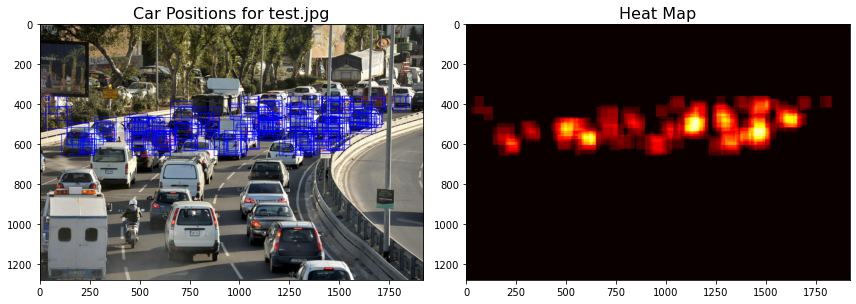

In [12]:
all_ystart = (360, 360, 360, 360)
all_ystop = (660, 660, 660, 660)
all_scales = (0.9, 1.1, 1.4, 1.7)

original_image = mpimg.imread('test.jpg')
image = original_image.astype(np.float32)/255.0

all_hot_windows = []
for ystart, ystop, scale in zip(all_ystart, all_ystop, all_scales):
    all_hot_windows += find_cars(image, ystart, ystop, scale, svc, 
                                 X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, 
                                 hist_bins, color_space)

out_image = draw_boxes(original_image, all_hot_windows)

heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, all_hot_windows)
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(original_image), labels)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(out_image)
ax1.set_title('Car Positions for test.jpg', fontsize=16)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=16)
f.tight_layout()

## Video Processing

In [13]:
def process_frame(original_image, heat_thresh=1, heat_queue = deque(maxlen=25), frlimit = 500):
    
    # Scale image from 0 to 1
    image = original_image.astype(np.float32)/255.0

        # Perform HOG subsampling as multiple scales
    all_ystart = (360, 360, 360, 360)
    all_ystop = (660, 660, 660, 660)
    all_scales = (0.9, 1.1, 1.4, 1.7)
    all_hot_windows = []
    for ystart, ystop, scale in zip(all_ystart, all_ystop, all_scales):
        all_hot_windows += find_cars(image, ystart, ystop, scale, svc, 
                                         X_scaler, orient, pix_per_cell, 
                                         cell_per_block, spatial_size, 
                                         hist_bins, color_space)


    heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
    heat = add_heat(heat, all_hot_windows)
        #print('heat max 1:', np.max(heat))

        # Add heat to circular buffer and find total
    heat_queue.append(heat)
    total_heat = np.sum(heat_queue, axis=0).astype(np.uint8)
        # Apply threshold to help remove false positives
    total_heat = apply_threshold(total_heat, heat_thresh)   
    heatmap = np.clip(total_heat, 0, 255)
        # Find final boxes from heatmap using label function
    labels = label(heatmap)

    out_image = draw_boxes(original_image, all_hot_windows)
    
    return draw_labeled_bboxes(np.copy(out_image), labels)

In [ ]:
input_video = 'E:/vehicle-detection-classification-opencv/CV Vids/20200327_160440.mp4'
output_video = 'sunny_hog.mp4'
clip = VideoFileClip(input_video)
processed = clip.fl_image(process_frame)
%time processed.write_videofile(output_video, audio=False)

Moviepy - Building video sunny_hog.mp4.
Moviepy - Writing video sunny_hog.mp4



t:   9%|▉         | 2023/21847 [2:08:47<20:24:39,  3.71s/it, now=None]   